# **\[SOLAR_A\]** GConvLSTM 5/10/30에폭 (X 안됨)

JiyunLim  
2023-08-17

-   MSE가 0.19~0.2XX 정도에서 더 낮아지지가 않는다 (classic, proposed
    모두)

# 2023.08.15 러너 수정

> **변경사항**: RGCN_Learner 수정 – 일부기능추가 **포인트**: 배치학습을
> 적용하여 update가 빨리이루어지도록 코드수정

## Import

In [69]:
# modules 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import eptstgcn
import eptstgcn.planner
import torch_geometric_temporal
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
import mplcyberpunk

# torch
import torch
import torch.nn.functional as F
#import torch_geometric_temporal
from torch_geometric_temporal.nn.recurrent import GConvLSTM
# from torch_geometric_temporal.nn.recurrent import GCLSTM
# from torch_geometric_temporal.nn.recurrent import LRGCN
# from torch_geometric_temporal.nn.recurrent import TGCN
# from torch_geometric_temporal.nn.recurrent import DCRNN

# read data
def makedict(FX,W=None,node_ids=None):
    T,N = np.array(FX).shape
    if W==None:
        W = pd.DataFrame(FX).corr().to_numpy().reshape(-1).tolist() # corr 로 weights
    if node_ids==None:
        node_ids = ['node'+str(n) for n in range(N)]
    _dict={
        'edges':[[i,j] for i in range(N) for j in range(N)], 
        'node_ids': node_ids,
        'weights':W,
        'FX':FX
    }
    return _dict

class Loader(object):
    def __init__(self, data_dict):
        self._dataset = data_dict
    
    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        # self._edge_weights = np.array(self._dataset["weights"]).T
        edge_weights = np.array(self._dataset["weights"]).T
        #scaled_edge_weights = minmaxscaler(edge_weights)
        self._edge_weights = edge_weights

    def _get_targets_and_features(self):
        stacked_target = np.stack(self._dataset["FX"])
        self.features = np.stack([
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])
        self.targets = np.stack([
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])


    def get_dataset(self, lags: int = 4) -> StaticGraphTemporalSignal:
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        dataset.node_ids = self._dataset['node_ids']
        return dataset
    
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

class RGCN_Learner:
    def __init__(self):
        self.method = 'RecurrentGCN'
        self.figs = []
        self.epochs = 0
        self.losses = []
        self._node_idx = 0
    def load(self,y): 
        if (self.lags is None) or (self.train_ratio is None):
            self.lags = 2 
            self.train_ratio = 0.8 
        self.t,self.n = y.shape
        dct = makedict(FX=y.tolist())
        self.loader = Loader(dct)
        self.dataset = self.loader.get_dataset(lags=self.lags)
        self.X = torch.tensor(self.dataset.features).float()
        self.y = torch.tensor(self.dataset.targets).float()
        self.train_dataset, self.test_dataset = eptstgcn.utils.temporal_signal_split(self.dataset, train_ratio = self.train_ratio)
        self.len_test = self.test_dataset.snapshot_count
        self.len_tr = self.train_dataset.snapshot_count
        #self.dataset_name = str(self.train_dataset) if dataset_name is None else dataset_name
        # self.train_dataset_batch = torch.utils.data.DataLoader(self.train_dataset,batch_size=256)
    def get_batches(self, batch_size=256):
        num_batches =  self.len_tr // batch_size + (1 if self.len_tr % batch_size != 0 else 0)
        self.batches = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            self.batches.append(self.train_dataset[start_idx:end_idx])
    
    def learn(self,epoch=1):
        self.model.train()
        for e in range(epoch):
            losses_batch = []
            for b,batch in enumerate(self.batches):
                loss = 0
                self.h, self.c = None, None
                for t, snapshot in enumerate(batch):
                    snapshot = snapshot.to(device)
                    yt_hat, self.h, self.c = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)
                    loss = loss + torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                    print(f'\rbatch={b}\t t={t+1}\t loss={loss/(t+1)}\t', end='', flush=True)
                loss = loss / (t+1)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                losses_batch.append(loss.item())
            self.epochs = self.epochs + 1
            print(f'\repoch={self.epochs}\t loss={np.mean(losses_batch)}\n', end='', flush=True)
        self.losses.append(np.mean(losses_batch))
        self._savefigs() 
    def _savefigs(self): 
        self.__call__()
        self._node_idx
        with plt.style.context('default'): 
            plt.ioff()
            plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
            fig,ax = plt.subplots()
            ax.plot(self.y[:,self._node_idx],label='real',lw=0.5)
            ax.plot(self.yhat[:,self._node_idx],'--',label='predited',alpha=0.5)
            ax.set_title(f'Epoch={self.epochs}, node_idx={self._node_idx}',size=15)
            ax.legend()
            #mplcyberpunk.add_glow_effects()  
        self.figs.append(fig)
        plt.close()
    def __call__(self,dataset=None):
        if dataset == None: 
            dataset = self.dataset
        self.yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)[0] for snapshot in dataset]).detach().squeeze().float()
        return {'X':self.X, 'y':self.y, 'yhat':self.yhat} 

# learn 
# def rgcn(FX,train_ratio,lags,filters,epoch):
#     dct = makedict(FX=FX.tolist())
#     loader = Loader(dct)
#     dataset = loader.get_dataset(lags=lags)
#     dataset_tr, dataset_test = eptstgcn.utils.temporal_signal_split(dataset, train_ratio = train_ratio)
#     lrnr = RGCN_Learner(dataset_tr, dataset_name = 'org & arbitrary')
#     lrnr.learn(filters=filters, epoch=epoch)
#     yhat = np.array(lrnr(dataset)['yhat'])
#     yhat = np.concatenate([np.array([list(yhat[0])]*lags),yhat],axis=0)
#     return yhat

In [70]:
class GConv_LSTM(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(GConv_LSTM, self).__init__()
        self.recurrent = GConvLSTM(in_channels = node_features, out_channels = filters, K = 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

## Load data

In [144]:
# read dataframe 
df = pd.read_csv('data_eng_230710.csv')

# make y, y_upper, y_period, time, regions 
y = df.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
yU = df.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
yP = np.divide(y, yU+1e-10)

t = df.loc[:,'date']
regions = list(df.loc[:, 'Bukchoncheon':'Gyeongju-si'].columns)

In [72]:
# global parameters
TRAIN_RATIO = 0.8
T, N = len(t), len(regions)
LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
LEN_TR = T - LEN_TEST

## sample_codes

`-` 예시1: y를 학습

**학습~**

In [73]:
epoch = 5

In [112]:
# step1: create lrnr object
lrnr = RGCN_Learner()
# step2: load data 
lrnr.lags = 4
lrnr.train_ratio = 0.8
lrnr.load(y) 
# step3: construct networks 
lrnr.nof_filters = 16
lrnr.model = GConv_LSTM(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(),lr=10/1000)
# step4: learn 
lrnr.get_batches(batch_size=24)
for e in range(epoch): ##    
    lrnr.learn()

epoch=1  loss=0.25450920699120955802826             
epoch=2  loss=0.085270544124204051455154            
epoch=3  loss=0.081624046141325042879562            
epoch=4  loss=0.07990403430059899768486             
epoch=5  loss=0.079772053091505247398148            

10에폭 더

In [89]:
for e in range(45):
    lrnr.learn()

epoch=6  loss=0.084969054279459084657288            
epoch=7  loss=0.086711541836171659044495            
epoch=8  loss=0.084869107534719074846878            
epoch=9  loss=0.085997803288317430316925            
epoch=10     loss=0.08763183830955694399521         
epoch=11     loss=0.08813722178253323977097         
epoch=12     loss=0.08270475915958021961044         
epoch=13     loss=0.08261586898981138861115         
epoch=14     loss=0.08332867805607793015442         
epoch=15     loss=0.08526128675615371949417         
epoch=16     loss=0.08475492060790922462784         
epoch=17     loss=0.08435604147353144033066         
epoch=18     loss=0.08424705243127983113144         
epoch=19     loss=0.08165435129126837348633         
epoch=20     loss=0.08078800713600115314758         
epoch=21     loss=0.08150773969760468311737         
epoch=22     loss=0.0816527509325465509909              
epoch=23     loss=0.08229979580311581530457         
epoch=24     loss=0.0824330328682134408767

In [113]:
yhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
yhat[yhat<0] = 0

In [114]:
classic = ((y - yhat)[LEN_TR:,:]**2).mean()
# proposed = ((y - yUhat*yPhat)[LEN_TR:,:]**2).mean()
print('classic(mse)', round(classic,4))
# print('proposed(mse)', round(proposed,4))

classic(mse) 0.2495

In [92]:
((lrnr.y - lrnr.yhat)[LEN_TR:,:]**2).mean()

In [93]:
epochs = lrnr.epochs
node_idx = 0

In [94]:
epochs

In [95]:
def rslt_plot(y, yhat, t_):
    with plt.style.context('default'): 
            plt.ioff()
            plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
            fig,ax = plt.subplots()
            ax.plot(y[:t_,node_idx],label='real',lw=0.5)
            ax.plot(yhat[:t_,node_idx],'--',label='predited',alpha=0.5)
            ax.set_title(f'Epoch={epochs}, node_idx={node_idx}',size=15)
            ax.legend()

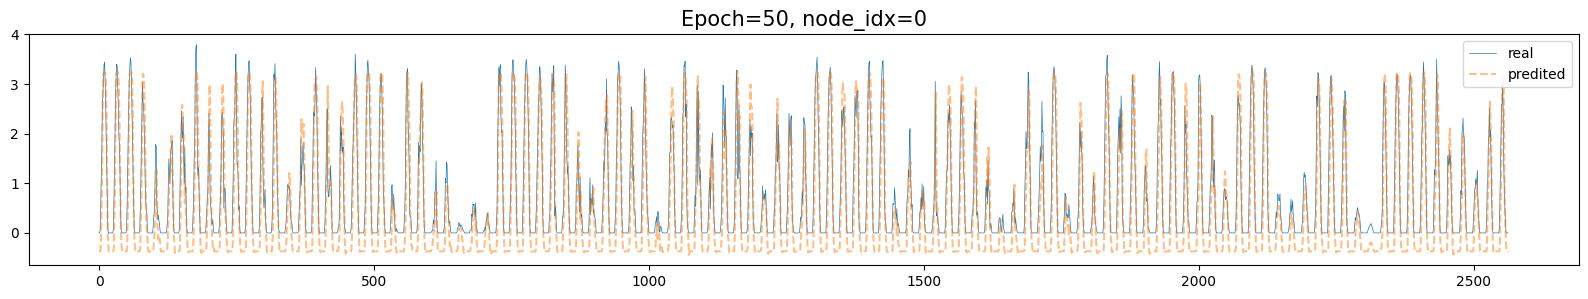

In [96]:
lrnr.figs[-1]

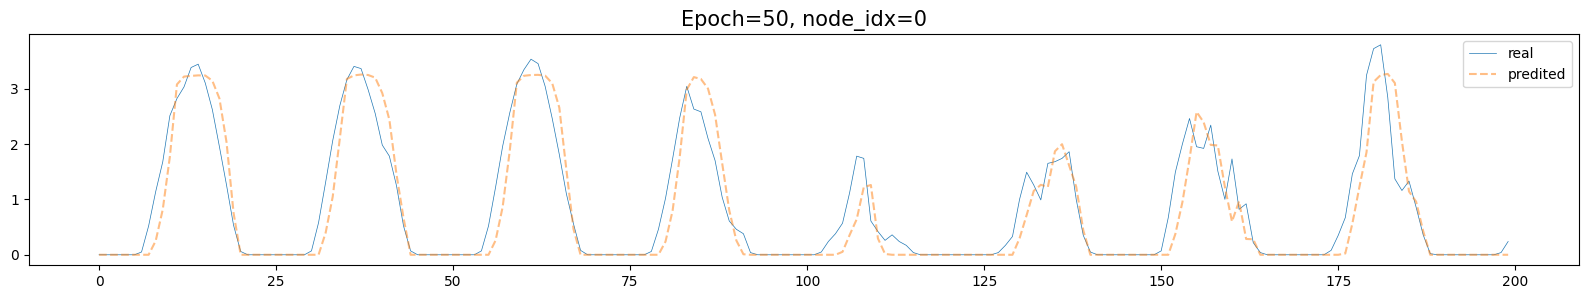

In [97]:
rslt_plot(y, yhat, 200)

**에폭별 적합결과($\hat{y}$) 시각화**

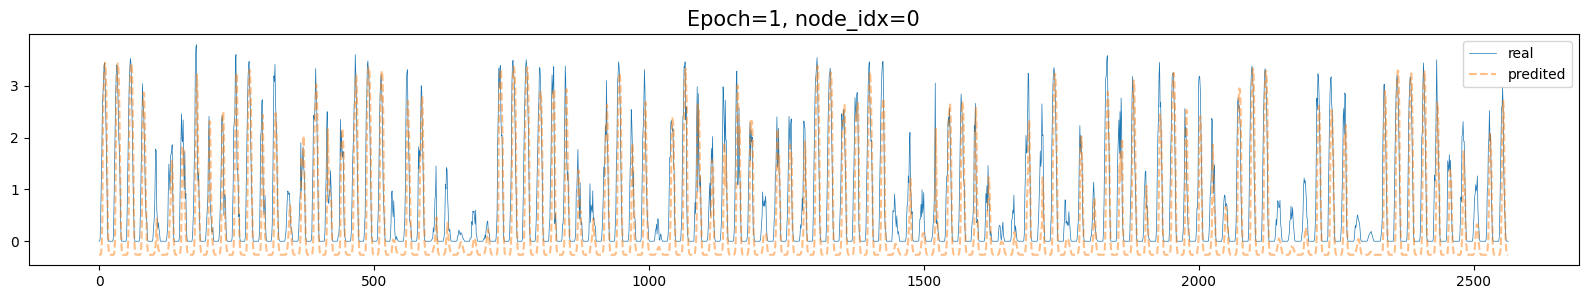

In [98]:
lrnr.figs[0]

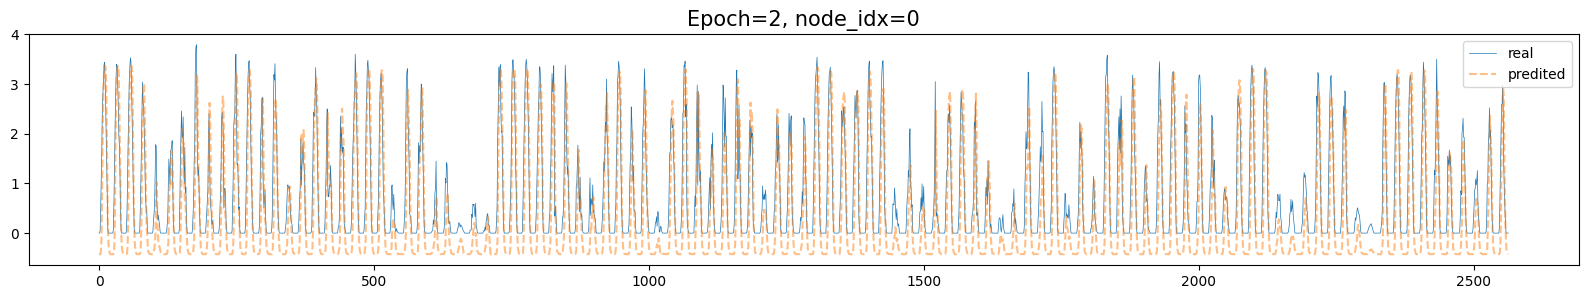

In [99]:
lrnr.figs[1]

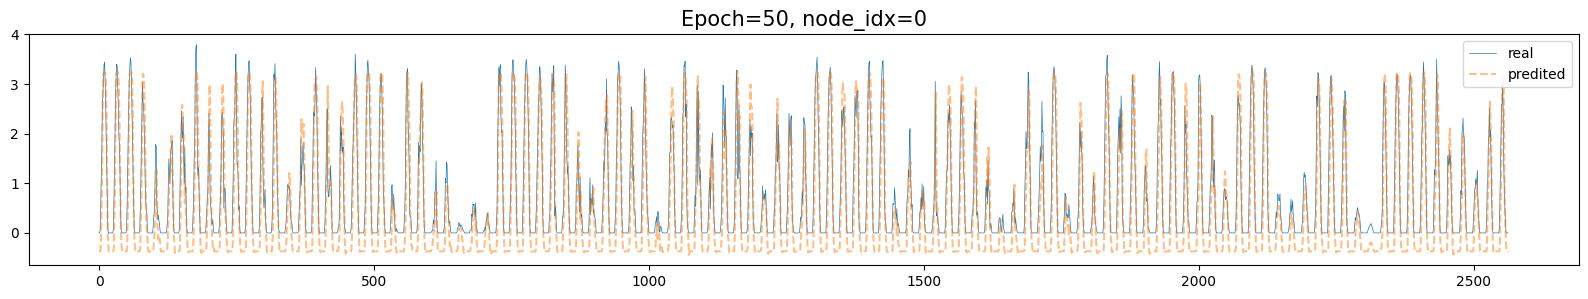

In [100]:
lrnr.figs[-1]

`-` 예시2: yU 학습

In [122]:
# step1: create lrnr object
lrnr = RGCN_Learner()
# step2: load data 
lrnr.lags = 4 
lrnr.train_ratio = 0.8
lrnr.load(yU) 
# step3: construct networks 
lrnr.nof_filters = 32
lrnr.model = GConv_LSTM(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(),lr=10/1000)
# step4: learn 
lrnr.get_batches(batch_size=24)
for e in range(50):    
    lrnr.learn()

epoch=1  loss=1.349797128591426507369995    
epoch=2  loss=0.074283774974647657434654        
epoch=3  loss=0.031608655539796197314644        
epoch=4  loss=0.0214767725434327552563362       
epoch=5  loss=0.0172472462696997985231018       
epoch=6  loss=0.0147337452129482525569153       
epoch=7  loss=0.014552190076819686361847            
epoch=8  loss=0.0119611411572022578715706       
epoch=9  loss=0.0115260377033548654699001       
epoch=10     loss=0.01001034026456520338969         
epoch=11     loss=0.009085335674002593908674        
epoch=12     loss=0.007716691838902270995741        
epoch=13     loss=0.008009002036360895054974        
epoch=14     loss=0.008109374055747203444124        
epoch=15     loss=0.007568856948975828283482        
epoch=16     loss=0.006784981698729098429171        
epoch=17     loss=0.0067525396345529798624744   
epoch=18     loss=0.006585374700587763994244        
epoch=19     loss=0.006784807498090316210777        
epoch=20     loss=0.0065407254340

In [123]:
yUhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)

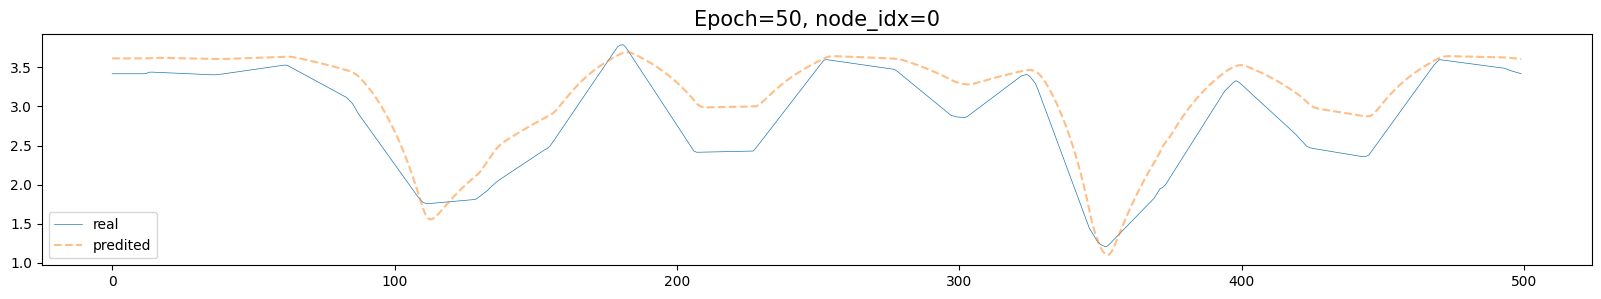

In [124]:
rslt_plot(yU, yUhat, 500)

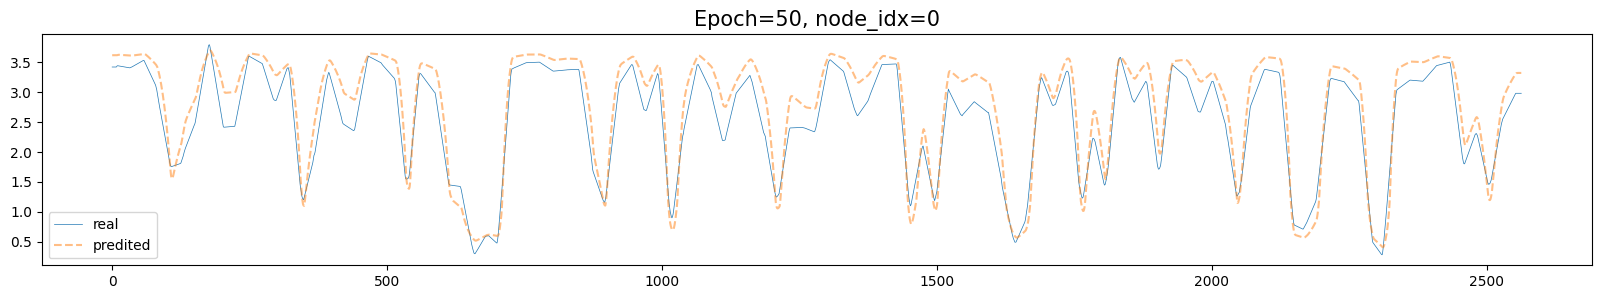

In [125]:
lrnr.figs[-1]

5번정도 더 돌려보자

In [17]:
# for e in range(5):    
#     lrnr.learn()

In [18]:
# lrnr.figs[-1] # 마지막 에폭 학습결과

`-` 예시3: yP 학습

In [115]:
# step1: create lrnr object
lrnr = RGCN_Learner()
# step2: load data 
lrnr.lags = 1 
lrnr.train_ratio = 0.8
lrnr.load(yP) 
# step3: construct networks 
lrnr.nof_filters = 32
lrnr.model = GConv_LSTM(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(),lr=10/1000)
# step4: learn 
lrnr.get_batches(batch_size=24)
for e in range(50):    
    lrnr.learn()

epoch=1  loss=0.0250301421836538376419296       
epoch=2  loss=0.0115632133580051264905643       
epoch=3  loss=0.0109912186040716283800583       
epoch=4  loss=0.0108431582758744634980202       
epoch=5  loss=0.0107451993687793115600777       
epoch=6  loss=0.0106557576936063201415443       
epoch=7  loss=0.0105818874990502652669716       
epoch=8  loss=0.010515016584852061447319            
epoch=9  loss=0.0104715230124785987782669       
epoch=10     loss=0.010432932431116527022678        
epoch=11     loss=0.01040628811934703035965         
epoch=12     loss=0.01038755040323405101027         
epoch=13     loss=0.010371074352554197884773        
epoch=14     loss=0.01035997818689793350961         
epoch=15     loss=0.010343652531277215081413        
epoch=16     loss=0.010330823116101931434208        
epoch=17     loss=0.010326810780815173870865        
epoch=18     loss=0.010312082193152937908691        
epoch=19     loss=0.010304978673703708634594        
epoch=20     loss=0.01029

In [116]:
yPhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
yPhat[yPhat<0] = 0

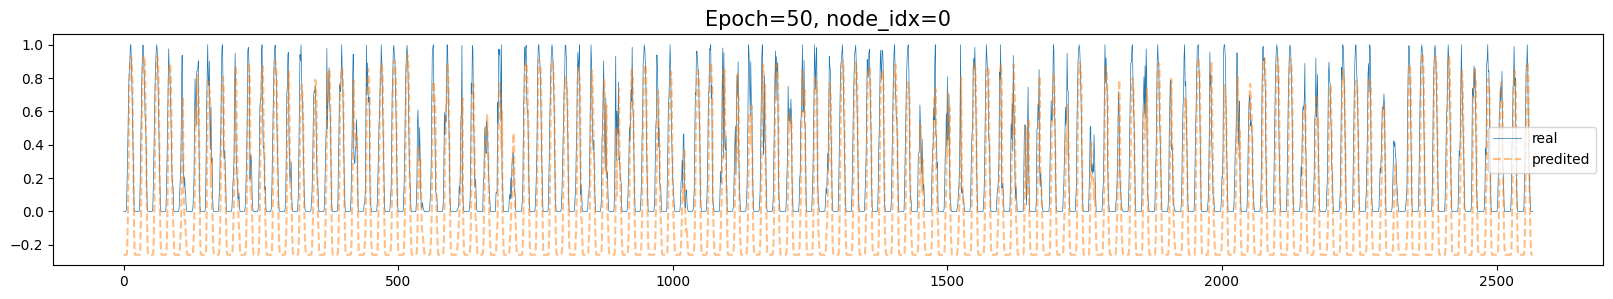

In [117]:
lrnr.figs[-1] 

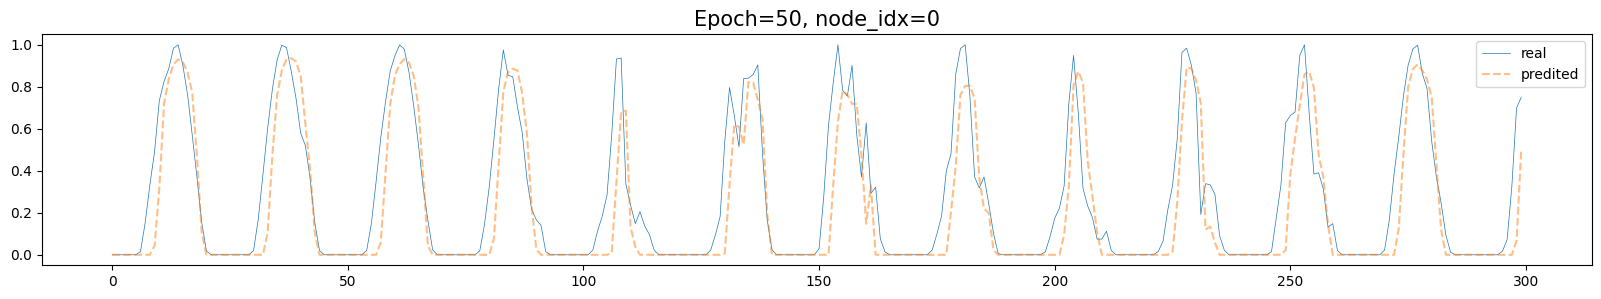

In [118]:
rslt_plot(yP, yPhat, 300)

`-` yUhat\*yPhat

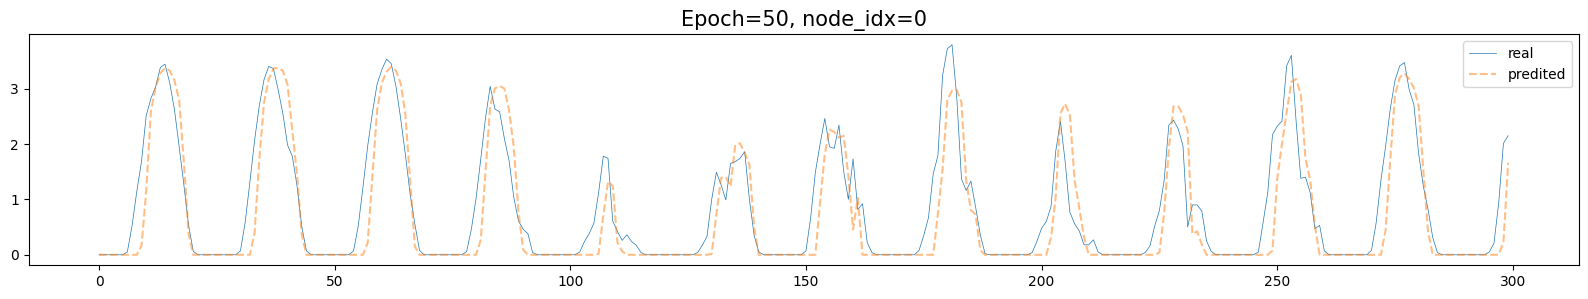

In [126]:
rslt_plot(y, yUhat*yPhat, 300)

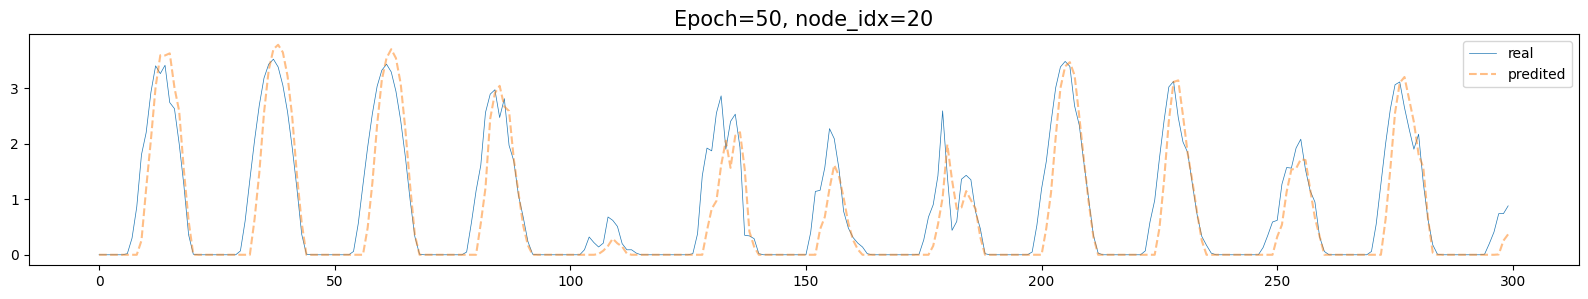

In [139]:
node_idx = 20
rslt_plot(y, yUhat*yPhat, 300)

`-` classic vs. proposed

In [140]:
classic = ((y - yhat)[LEN_TR:,:]**2).mean()
proposed = ((y - yUhat*yPhat)[LEN_TR:,:]**2).mean()
print('classic(mse)', round(classic,4))
print('proposed(mse)', round(proposed,4))

classic(mse) 0.2495
proposed(mse) 0.1811

`-` loss

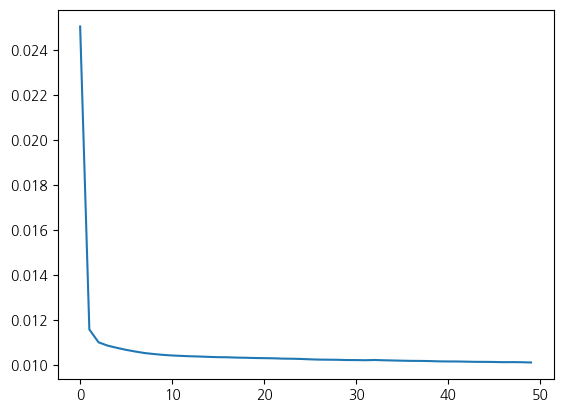

In [121]:
plt.plot(lrnr.losses)